In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("bitcoin.csv")

In [3]:
import numpy as np
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import plotly.offline as py
import plotly.graph_objs as go

import keras_tuner as kt

In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
df = df.set_index('Timestamp')
df['price'] = (df['High']+ df['Low'])/2
df = df.resample('6H').mean()
df = df.dropna()

In [6]:
prediction_days = 500
df_train= df['price'][:len(df['price'])-prediction_days].values.reshape(-1,1)
df_test= df['price'][len(df['price'])-prediction_days:].values.reshape(-1,1)

scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [7]:
def create_dataset(dataset, look_back=30):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(scaled_train)
testX, testY = create_dataset(scaled_test)

In [8]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), return_sequences=True, input_shape= ( trainX.shape[1], trainX.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(30, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
   
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    
    return model
    
tuner = kt.RandomSearch(model_builder, objective="mse", max_trials = 1, executions_per_trial =1,directory = "./")

tuner.search(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False)

Trial 3 Complete [02h 38m 53s]
mse: 0.07578344643115997

Best mse So Far: 0.0013964830432087183
Total elapsed time: 02h 38m 53s
INFO:tensorflow:Oracle triggered exit


In [10]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
input_unit: 32
n_layers: 3
lstm_0_units: 96
layer_2_neurons: 64
Dropout_rate: 0.45
dense_activation: sigmoid
lstm_1_units: 32
lstm_2_units: 32
Score: 0.0013964830432087183
Trial summary
Hyperparameters:
input_unit: 416
n_layers: 2
lstm_0_units: 448
layer_2_neurons: 512
Dropout_rate: 0.35000000000000003
dense_activation: relu
lstm_1_units: 32
lstm_2_units: 256
Score: 0.07578344643115997


In [11]:
best_model = tuner.get_best_models(num_models=1)[0]

In [12]:
history = best_model.fit(x=trainX, y=trainY, epochs = 150, batch_size =128, validation_data=(testX, testY), shuffle=False, verbose=0)

In [14]:
predicted_BTC_price = best_model.predict(testX)

In [15]:
predicted_BTC_price = scaler_test.inverse_transform(predicted_BTC_price.reshape(-1, 1))

In [16]:
true = scaler_test.inverse_transform(testY.reshape(-1, 1))

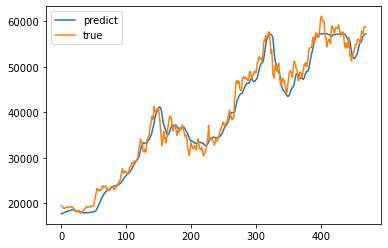

In [17]:
pyplot.plot(predicted_BTC_price, label='predict')
pyplot.plot(true, label='true')
pyplot.legend()
pyplot.show()